# CIS 5450 Project: Machine Learning

Team members: Baojia Liu, Xiaoyong Cai (Wesley) , Ramanpreet Bhatia


# Introduction

As consumers, we care about what we eat every day and what we give to our children. We created models to predict nutrition grade/scores for the products  and our peoject could give recommendations based on nutrition scores which will help people make better choices for similar food items.

We also care about food products that are high in sugar or other nutrients that might not be healthy for long-term and excessive consumption. Considering there are alternative nutritional foods available, we would like to make healthy food choices by working on this project. 

# 0 Setup

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import sequence
spark = SparkSession.builder.master("local[*]").getOrCreate()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 2s (127 kB/s)
Reading package lis

# 1 Data Loading and Preprocessing



## 1.1 Partitioning Open Food Facts Dataset

In [ ]:
# Row Partitioning
# Notes: please update the input_dir & output_dir before running
input_dir = "drive/My Drive/545_project/data/en.openfoodfacts.org.products.csv" # "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/en.openfoodfacts.org.products.csv"
output_dir = "drive/My Drive/545_project/data/partitions/"

num_partitions = 10

for r in range(num_partitions):
  print("working on ",r," th partition job")
  i = 0
  text = ""
  with open(input_dir, encoding='UTF-8') as f:
    header = f.readline()
    text += header

    while True:
      line = f.readline()
      if not line:
          break

      # The remainder (row index divide by num_partitions) would decide which partition file go to
      if i % num_partitions == r:
        text += line
      i += 1

  output_filename = output_dir + "p"+ str(r) +".csv"
  with open(output_filename, 'w', encoding='UTF8') as f:
    f.write(text)

## 1.2  Dataset Open Food Facts


The dataset we used for this project is from Open Food Facts (https://world.openfoodfacts.org/data). We downloaded the most recent csv file and saved it into google drive. The full dataset contains 196 columns * 2640596 rows.

In [ ]:
# mount Google Grive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from Google Drive

# path = "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/partitions/p0.csv"
# path = "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/100k.csv"
# path = "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/en.openfoodfacts.org.products.csv"
path = "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/en.openfoodfacts.org.products.csv" # wesley

df = spark.read.option("encoding", "UTF-8").option("delimiter", "\t").option("header", "True").csv(path)
df.show()
df.count()
# len(df.columns)

+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------------+-------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------

2640596

To cleaning the rows, since we used the 'product_name' column as the key coulmn, we dropped any rows without a product name. We kept all the other 2547006 rows for now.





In [ ]:
# Drop rows with NaN in 'product_name' column and keep all the other rows for now. 

df = df.na.drop(subset=["product_name"])
df.show()
# df.count()


+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------------+-------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------

To clean the columns, since the dataset contains a large number of NaN values, we set a threshold as 5% and dropped any columns with less than 5% coverage. We kept all the other 89 columns for now. Saved the new dataset into new_df.

In [ ]:
# Get the ratio of null values in each column
from pyspark.sql.functions import col, count, isnan, lit, sum

def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True ->  1
    """
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

df.agg(*[count_not_null(c) for c in df.columns]).show()
exprs = [(count_not_null(c) / count("*")).alias(c) for c in df.columns]
df_null_ratio = df.agg(*exprs)
df_null_ratio.show()

+-------+-------+-------+---------+----------------+---------------+----------------------+------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------+-----------+----------+---------------+-------------+-------+------------+----------+--------------------+-------------------------+------+-----------+---------+---------+--------------+------------------------+------+-----------+---------------+------+---------+--------------+------------+----------------+----------------+-------------------------+---------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------+------------+----------------+----------------+----------+-------------+-------------+-----------+----------------+--------------+-------+-----------+---------+-----------+--------------+--------------+--------------------+----------------+-----+------------------------+--------------+---------------+--

In [ ]:
# Drop columns with < 5% coverage
ratios = df_null_ratio.select(*[c for c in df.columns]).first()
cols_to_drop = [c for c in ratios.asDict() if ratios[c] < 0.05]
new_df = df.drop(*cols_to_drop)
new_df.show()
new_df.count()
len(new_df.columns)

+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------+--------+---------+--------------+------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+-----------+---------+------------+----------------+-----------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+--------------+--------------------+----------------+--------------+--------

89

# 2 EDA

## 2.1 Average nutrition score

In [ ]:
# remove rows with null nutriscore_score or nutriscore_grade
df_2 = new_df.filter((new_df.nutriscore_grade.isNotNull()) & (new_df.nutriscore_score.isNotNull()))
df_2.show()

+--------------------+--------------------+---------------+----------+--------------------+---------------+----------------------+--------------------+------------+--------+--------------------+------------------+------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------------+----------------+----------------+----------+--------------+---------------+-------------+-------------+----------------+-------------+--------------------+--------------------+-------------------------+-----------------+-----------------+-----------+---------------+----------------+-----------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+--------------+-----------

In [ ]:
# generate average nutrition score for countries
df_2.createOrReplaceTempView("df_2")

sdf = spark.sql('''
SELECT countries_en,nutriscore_score
FROM df_2
''')
score_countries_pdf = sdf.toPandas().astype({'nutriscore_score':'int32'})

score_countries_pdf['country'] = score_countries_pdf["countries_en"].str.split(",")
score_countries_pdf = score_countries_pdf.explode("country")
# score_countries_pdf.head()

ave_score_df = score_countries_pdf.dropna(subset=['nutriscore_score']).groupby(['country'])['nutriscore_score'].mean().reset_index()
ave_score_df.head()

,country,nutriscore_score
0,Afganistan,18.000000
1,Afghanistan,9.719298
2,Afrique-du-sud,27.000000
3,Agypten,26.000000
4,Albania,10.650000


In [ ]:
#
ave_score_max = ave_score_df['nutriscore_score'].max()
ave_score_list = [[ave_score_df['country'][i],round(ave_score_df['nutriscore_score'][i], 2)] for i in range(len(ave_score_df))] #prepare data for visualization
print(ave_score_list[:3])

[['Afganistan', 18.0], ['Afghanistan', 9.72], ['Afrique-du-sud', 27.0]]


In [ ]:
!pip install pyecharts
from pyecharts.charts import Map,Geo
from pyecharts import options as opts
from pyecharts.globals import ThemeType
import IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 34.8 MB/s 
     |████████████████████████████████| 139 kB 67.3 MB/s 


In [ ]:
map_1 = Map(init_opts=opts.InitOpts(width='1400', height='600px')) #create the map and set the size of the map
map_1.add('Average Nutriscore Score', ave_score_list, maptype='world') #add world map
map_1.set_series_opts(label_opts=opts.LabelOpts(is_show=False)) #remove country names
map_1.set_global_opts( #set global configurations
 title_opts=opts.TitleOpts(title="Nutricore In Different Countries"),
 visualmap_opts=opts.VisualMapOpts( max_=ave_score_max,  is_piecewise=False),
 legend_opts=opts.LegendOpts(is_show=False), #show legend or not
 )
# map_1.render_notebook() #show the map in the notebook directly # it works at Jupyter Notebook, but not google colab
map_1.render('ave_score.html')
IPython.display.HTML(filename='ave_score.html')

## 2.2 Organic food vs. non-organic food

Organic food is considered to be safer, heathier than non-organic food, and it usually has a higher price. We wanted to study the open food dataset to see if organic food does have a better nutrition score/grade compared to non-organic food. We analized the dataset by answering following three questions to get a better understanding of organic food.


1.   Do organic food products have a lower nutrition score (better score) than non-organic food products?
2.   Do organic food products have a better nutrition grade ('a' is the best, 'e' is the worst) than non-organic food products?
3.   The average values of some common nutrients in organic and non-organinc food.



### 2.2.1 Average nutrition score

Filtered out the rows with both nutrition score and nutrition grade, and calculated the average nutrition scores for organic and non-organic food. 

In [ ]:
# drop rows with null nutrition score or nutrition grade, save the new df into df_2
df_2 = new_df.filter((new_df.nutriscore_grade.isNotNull()) & (new_df.nutriscore_score.isNotNull()))
df_2.show()

+--------------------+--------------------+---------------+----------+--------------------+---------------+----------------------+--------------------+------------+--------+--------------------+------------------+------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------------+----------------+----------------+----------+--------------+---------------+-------------+-------------+----------------+-------------+--------------------+--------------------+-------------------------+-----------------+-----------------+-----------+---------------+----------------+-----------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+--------------+-----------

In [ ]:
# Organic food
df_2.createOrReplaceTempView("df_2")
sdf = spark.sql('''
SELECT AVG(nutriscore_score) AS organic_average_score 
FROM df_2 
WHERE labels_en = "Organic"
''')
sdf.show()

+---------------------+
|organic_average_score|
+---------------------+
|     6.02549829412821|
+---------------------+



In [ ]:
# Non-organic food
sdf = spark.sql('''
SELECT AVG(nutriscore_score) AS non_organic_average_score 
FROM df_2 
WHERE labels_en <> "Organic"
''')
sdf.show()

+-------------------------+
|non_organic_average_score|
+-------------------------+
|        8.581500771604938|
+-------------------------+



We wonder if it is a significantly different between **organic** nutriscore_score (mean:6.026) and **non organic** nutriscore_score (mean: 8.587)

In [ ]:
# generate organic nutrition scores
sdf_org = spark.sql('''
SELECT labels_en,nutriscore_score
FROM df_2 
WHERE labels_en = "Organic"
''')
df_org = sdf_org.toPandas().astype({'nutriscore_score':'int32'})
df_org.head()

,labels_en,nutriscore_score
0,Organic,5
1,Organic,-7
2,Organic,1
3,Organic,0
4,Organic,4


In [ ]:
# generate non-organic nutrition scores
sdf_non_org = spark.sql('''
SELECT labels_en,nutriscore_score
FROM df_2 
WHERE labels_en <> "Organic"
''')
df_non_org = sdf_non_org.toPandas().astype({'nutriscore_score':'int32'})
df_non_org.head()

,labels_en,nutriscore_score
0,fr:delois-france,18
1,No palm oil,2
2,"French meat,Made in France",0
3,Green Dot,2
4,"Organic,EU Organic,Non-EU Agriculture,EU Agric...",0


We are conducting hypothesis test **t-test** using package **researchpy** and **Scipy.stats**
to test if it is a significantly difference between two scores.

**The null hypothese**: there is no difference 

In [ ]:
!pip install researchpy
import researchpy as rp
import scipy.stats as stats

rp.ttest(group1= df_org['nutriscore_score'], group1_name= "Organic",
         group2= df_non_org['nutriscore_score'], group2_name= "Non_Organic")

# Ref: https://www.pythonfordatascience.org/independent-samples-t-test-python/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(      Variable         N      Mean        SD        SE  95% Conf.  Interval
 0      Organic   22276.0  6.025498  8.099221  0.054266   5.919134  6.131863
 1  Non_Organic  259200.0  8.581501  8.752799  0.017192   8.547805  8.615197
 2     combined  281476.0  8.379219  8.730161  0.016455   8.346967  8.411470,
                       Independent t-test      results
 0  Difference (Organic - Non_Organic) =       -2.5560
 1                  Degrees of freedom =   281474.0000
 2                                   t =      -42.0644
 3               Two side test p value =        0.0000
 4              Difference < 0 p value =        0.0000
 5              Difference > 0 p value =        1.0000
 6                           Cohen's d =       -0.2937
 7                           Hedge's g =       -0.2937
 8                      Glass's delta1 =       -0.3156
 9                    Point-Biserial r =       -0.0790)

**Interpretation:**

The average nutri score for organic, Mean = 5.7 (5.608249, 5.826974), was statistically signigicantly higher than non organic, Mean = 8.4 (8.389664, 8.458076); **t_statistic= -43.9243, p= 0.0000**


From the results above we know organic food do have a better nutrition score than non-organic food products.

(Note: Smaller nutrition score tends to be better)

### 2.2.2 Nutrition grades

Visualize the distribution of nutrition grades for organic and non-organic food.

In [ ]:
# Organic food grade distribution
sdf = spark.sql('''
SELECT nutriscore_grade, COUNT(*) AS cnt
FROM df_2
WHERE labels_en = "Organic"
GROUP BY 1
ORDER BY 1
''')
sdf.show()
pdf = sdf.select('*').toPandas()

+----------------+----+
|nutriscore_grade| cnt|
+----------------+----+
|               a|5332|
|               b|3862|
|               c|5137|
|               d|5355|
|               e|2590|
+----------------+----+



sum 22276


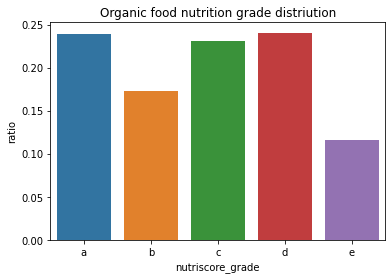

In [ ]:
# visualize the organic distribution
import seaborn as sns
import matplotlib.pyplot as plt
s = pdf['cnt'].sum()
print('sum', s)
pdf['ratio'] = pdf['cnt'] / s
plt.figure()
ax = sns.barplot(data=pdf, x='nutriscore_grade', y='ratio')
plt.title("Organic food nutrition grade distriution")
plt.show()

In [ ]:
# non-organic food nutrition grade distribution
sdf = spark.sql('''
SELECT nutriscore_grade, COUNT(*) AS cnt
FROM df_2
WHERE labels_en <> "Organic"
GROUP BY 1
ORDER BY 1
''')
sdf.show()
pdf = sdf.select('*').toPandas()

+----------------+-----+
|nutriscore_grade|  cnt|
+----------------+-----+
|               a|42602|
|               b|39677|
|               c|57168|
|               d|74371|
|               e|45382|
+----------------+-----+



sum 259200


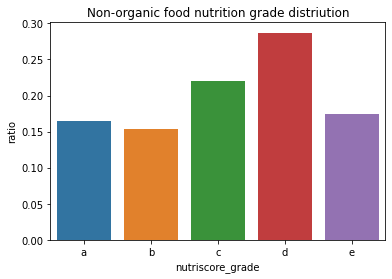

In [ ]:
# # visualize the non-organic distribution
s = pdf['cnt'].sum()
print('sum', s)
pdf['ratio'] = pdf['cnt'] / s
pdf
plt.figure()
ax = sns.barplot(data=pdf, x='nutriscore_grade', y='ratio')
plt.title("Non-organic food nutrition grade distriution")
plt.show()

It is known from the results above, more than 40% of the the organic food products are in a or b, while there are around 30% of non-organic food products are in a or b grade. The difference of the ratio was notas much as we expected, but it is still the fact we got from the dataset that organic food is more likely to be in better nutrition grades in genreal.


### 2.2.3 Common nutriants average amount




We selected a few common nutrients and compare their average amount between organic and non-organic food. Since the dataset contain outlier, we remove the rows with extreme values and kept the rest for the analysis.

In [ ]:
# calculate the average amount for each nutrient in orgnic food and non-organic food respectively
# remove the outlier
sdf = spark.sql('''
SELECT
    CASE
        WHEN labels_en = "Organic" THEN "Organic"
        ELSE "Non-organic"
    END AS type_of_food,
    AVG(`energy_100g`) AS `Avg_energy_100g`,
    AVG(`fat_100g`) AS `Avg_fat_100g`,
    AVG(`saturated-fat_100g`) AS `Avg_saturated-fat_100g`,
    AVG(`trans-fat_100g`) As `Avg_trans-fat_100g`,
    AVG(`cholesterol_100g`) AS `Avg_cholesterol_100g`,
    AVG(`carbohydrates_100g`) AS `Avg_carbohydrates_100g`,
    AVG(`sugars_100g`) AS `Avg_sugars_100g`,
    AVG(`fiber_100g`) AS `Avg_fiber_100g`,
    AVG(`proteins_100g`) AS `Avg_proteins_100g`,
    AVG(`salt_100g`) AS `Avg_salt_100g`,
    AVG(`sodium_100g`) AS `Avg_sodium_100g`,
    AVG(`vitamin-a_100g`) AS `Avg_vitamin-a_100g`,
    AVG(`vitamin-c_100g`) AS `Avg_vitamin-c_100g`,
    AVG(`calcium_100g`) AS `Avg_alcium_100g`,
    AVG(`iron_100g`) AS `Avg_iron_100g`,
    AVG(`fruits-vegetables-nuts-estimate-from-ingredients_100g`) AS `Avg_fruits-vegetables-nuts_100g`
FROM df_2
WHERE
    `energy_100g` < 4000 AND
    `fat_100g` < 100 AND
    `saturated-fat_100g` < 100 AND
    `trans-fat_100g` < 100 AND
    `cholesterol_100g` < 100 AND
    `carbohydrates_100g` < 100 AND
    `sugars_100g` < 100 AND
    `fiber_100g` < 100 AND
    `proteins_100g` < 100 AND
    `salt_100g` < 100 AND
    `sodium_100g` < 100 AND
    `vitamin-a_100g` < 100 AND
    `vitamin-c_100g` < 100 AND
    `calcium_100g` < 100 AND
    `iron_100g` < 100 AND
    `fruits-vegetables-nuts-estimate-from-ingredients_100g` < 100
GROUP BY 1 
''')
pdf = sdf.select('*').toPandas()
pdf

In [ ]:
# caculate and compare the ratio of nutrition grades for organic and non-organic food 
nutritions = []
types = []
amounts = []
for i, c in enumerate(pdf.columns):
    if i == 0:
        continue
    row = pdf[c]
    nutritions.append(c)
    max_value = max(row[0], row[1])
    types.append('Organic')
    amounts.append(1.0 * row[0] / max_value)
    nutritions.append(c)
    types.append('Non organic')
    amounts.append(1.0 * row[1] / max_value)

In [ ]:
import pandas as pd
graph_df = pd.DataFrame({"Nutrition": nutritions, "Type": types, 'Amount': amounts})

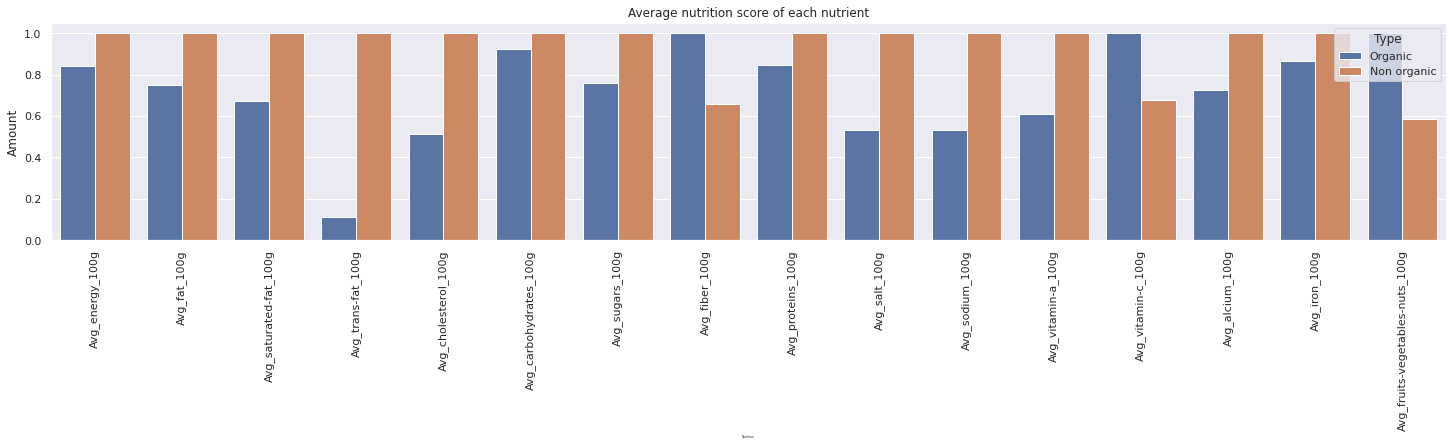

In [ ]:
# Visualize the comparison of organic and non-organic food for the average amount of each nutrient
plt.figure(figsize=(25,4))
ax = sns.barplot(data=graph_df, x='Nutrition', y='Amount', hue='Type')
ax.set_xlabel('Nutrition', fontsize=3)
plt.xticks(rotation=90)
plt.title('Average nutrition score of each nutrient')
plt.show()

From the results above, it seems only for fiber, vitamin-c, and fruits-vegetables-nuts, organic food has a higher average value. It is not defenite that organic food contains more amount of nutrition than non-rganic food based on the dataset. We also need to mention that this observation may contain bias since we didn't consider the fod categories and a different outlier range may also affect the results.

## 2.3 Additives and nutrition score/grade 

Many people care about if a food product contains additives since in commen sense, the more addtives the less heathy the food is. We studied the dataset to see what is the correlation between the number of additives in a food product and its nutrition score/grade. We also showed the distribution of number of additives on a world map.

### 2.3.1 Correlations between number of additives and nutrition scores

In [ ]:
# generate the num_additives and score pairs from the dataset 
# sort in ascending order of scores (good to bad)
sdf = spark.sql('''
SELECT CAST(additives_n AS INT) AS num_additives, AVG(nutriscore_score) AS score 
FROM df_2
GROUP BY 1
ORDER BY 1 ASC
''')
pdf = sdf.select('*').toPandas()
pdf

,num_additives,score
0,NaN,9.511414
1,0.0,5.947432
2,1.0,10.176917
3,2.0,11.088757
4,3.0,11.618314
5,4.0,11.741309
6,5.0,11.483851
7,6.0,11.664539
8,7.0,11.808649
9,8.0,12.693569


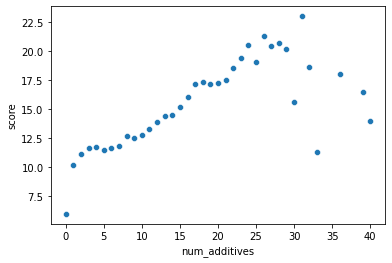

In [ ]:
# visualize the resuts above
plt.figure()
ax = sns.scatterplot(data=pdf, x='num_additives', y='score')
plt.show()

It is not surprise to see that there is a trend that the more number of additives added to the food product the higher score (lower grade) the food has.

### 2.3.2 Number of additives ased aer food item in different country

In [ ]:
sdf = spark.sql('''
SELECT countries_en,additives_n
FROM df_2
WHERE additives_n IS NOT NULL
''')
additives_countries_pdf = sdf.toPandas().astype({'additives_n':'int32'})
additives_countries_pdf.head()

In [ ]:
additives_countries_pdf['country'] = additives_countries_pdf["countries_en"].str.split(",")
additives_countries_pdf = additives_countries_pdf.explode("country")
ave_num_add_df = additives_countries_pdf.dropna(subset=['additives_n']).groupby(['country'])['additives_n'].mean().reset_index()
print( ave_num_add_df.head() )

ave_num_add_max = ave_num_add_df['additives_n'].max()
ave_num_add_list = [[ave_num_add_df['country'][i],round(ave_num_add_df['additives_n'][i],1)] for i in range(len(ave_num_add_df))] #prepare data for visualization
print( ave_num_add_list[:3] )

In [ ]:
map_1 = Map(init_opts=opts.InitOpts(width='1400px', height='600px')) #create the map and set the size of the map
map_1.add('Average Number of Addtives', ave_num_add_list, maptype='world') #add world map
map_1.set_series_opts(label_opts=opts.LabelOpts(is_show=False)) #remove country names
map_1.set_global_opts( #set global configurations
 title_opts=opts.TitleOpts(title="Number of Additives Used Per Food Item in Different Country"),
 visualmap_opts=opts.VisualMapOpts( max_=ave_num_add_max,  is_piecewise=True),
 legend_opts=opts.LegendOpts(is_show=False), #show legend or not
 )
map_1.render_notebook() #show the map in the notebook directly
map_1.render('num_add.html')
IPython.display.HTML(filename='num_add.html')

## 2.4 Source of nutritions

We analyzed which food categories can provide certain nutrients, then we can make smart choices on food based on our needs of nutrients.

In [ ]:
# explode the food group column
# we will use it as food category
from pyspark.sql.functions import split, col
df_3 = new_df.select('*', split(col("food_groups_en"),",").alias("food_groups_array"))
df_3.printSchema()
df_3.show()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable = true)
 |-- labels_en: string (nullabl

In [ ]:
# explode the food group column to get the food category for each products. Some food products belong to multiple categories.
from pyspark.sql.functions import explode
df_3 = df_3.select('*', explode(df_3.food_groups_array).alias('food_group'))

In [ ]:
# select nutrients that people like to take supplements for as targe nutrients in our study.
# create a dictionary to store index and food category in order of the contained amount of each nutrient. 
# the smaller the index number, the higher amount of the nutrient contained in the category.
df_3.createOrReplaceTempView("df_3")
pdfs = {}
for s in ['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']:
    sdf = spark.sql('''
    SELECT food_group, AVG(`{}`) AS amount
    FROM df_3
    GROUP BY 1
    ORDER BY amount DESC
    '''.format(s))
    pdfs[s] = sdf.toPandas()

Just to note, since we didn't include the specific amounts of nutrients contained in each category into calculation and the index cannot fully represent how good or bad source a category is, the order below just shows a tendency but is not a serious order of good nutrient sources.

In [ ]:
# sum the index of each food category over all nutrients. A smaller sum indicates the food category can provide more amount or more varieties of nutrients. 
counter_dict = {}
for s in ['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']:
# for s in ['energy_100g']:
    for index, row in pdfs[s].iterrows():
        # print(row['food_group'], row['amount'])
        food_group = row['food_group']
        if food_group in counter_dict:
            counter_dict[food_group] += index
        else:
            counter_dict[food_group] = index
dict(sorted(counter_dict.items(), key=lambda item: item[1]))

{'Breakfast cereals': 29,
 'Milk and dairy products': 81,
 'Dried fruits': 82,
 'Cheese': 87,
 'Cereals and potatoes': 93,
 'Pastries': 93,
 'Nuts': 98,
 'Cereals': 101,
 'Salty snacks': 102,
 'Salty and fatty products': 106,
 'Vegetables': 108,
 'Artificially sweetened beverages': 111,
 'Fruits and vegetables': 112,
 'Fish and seafood': 116,
 'One-dish meals': 121,
 'Composite foods': 121,
 'Chocolate products': 128,
 'Sandwiches': 128,
 'Fish‚ Meat‚ Eggs': 128,
 'Sugary snacks': 140,
 'Biscuits and cakes': 141,
 'Fatty fish': 142,
 'Milk and yogurt': 143,
 'Legumes': 145,
 'Fats': 150,
 'Beverages': 150,
 'Potatoes': 152,
 'Fruit juices': 159,
 'Sweets': 160,
 'Unsweetened beverages': 162,
 'Pizza pies and quiches': 167,
 'Dairy desserts': 167,
 'Bread': 171,
 'Appetizers': 175,
 'Fruits': 176,
 'Fats and sauces': 180,
 'Sweetened beverages': 183,
 'Meat other than poultry': 188,
 'Processed meat': 191,
 'Meat': 193,
 'Plant-based milk substitutes': 195,
 'Dressings and sauces': 200,

It can be seem from the results above, breakfast cereals has the best score. This maybe because they were made to be a good source of nutriens, so more varieties of nutrients were added to reach that purpose. Other categories, such as meat, eggs, fruits, they are good sources of some specific nutrients but may not contain as good variety of nutrients as processed food. It is also worth mentioned that milk and dairy products, dried fruits, and cheese also have a high rank. It would be a good choice to add more of these categories to our daily diet.

## 2.5 High fat foods and countries

Is it true that food in the US is less healthy due to a common stereotype that US food products contain more fats as compared to European food products?

Lets explore this question 

In [ ]:
new_df.createOrReplaceTempView("sdf")

In [ ]:
sql_q = spark.sql('''
select countries_en, 
cast(fat_100g as float) fat_100g, 
cast(`saturated-fat_100g` as float) `saturated-fat_100g`,
cast(`trans-fat_100g` as float) as `trans-fat_100g`,
 ingredients_text, 
cast( `cholesterol_100g` as float) as `cholesterol_100g`, 
cast( `carbohydrates_100g` as float) as `carbohydrates_100g`,
cast( `sugars_100g` as float) as `sugars_100g`, 
cast( `energy_100g` as float) as `energy_100g`
from sdf
where countries_en in ('United States', 'France', 'Italy', 'Germany', 'Belgium', 'Spain', 'Denmark', 'Switzerland')
''')

In [ ]:
df = sql_q.select('*').toPandas()

In [ ]:
df.shape

(2074985, 9)

In [ ]:
df.head()

,countries_en,fat_100g,saturated-fat_100g,trans-fat_100g,ingredients_text,cholesterol_100g,carbohydrates_100g,sugars_100g,energy_100g
0,France,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,Germany,2.0,2.00,NaN,None,NaN,65.000000,12.6,690.0
2,Spain,1.4,0.90,NaN,"Leche semidesnatada, azucar 6.9%, leche desnat...",NaN,9.800000,9.8,NaN
3,France,0.2,0.10,NaN,None,NaN,3.900000,3.9,238.0
4,France,7.0,3.08,NaN,None,NaN,70.099998,15.0,1569.0


In [ ]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})

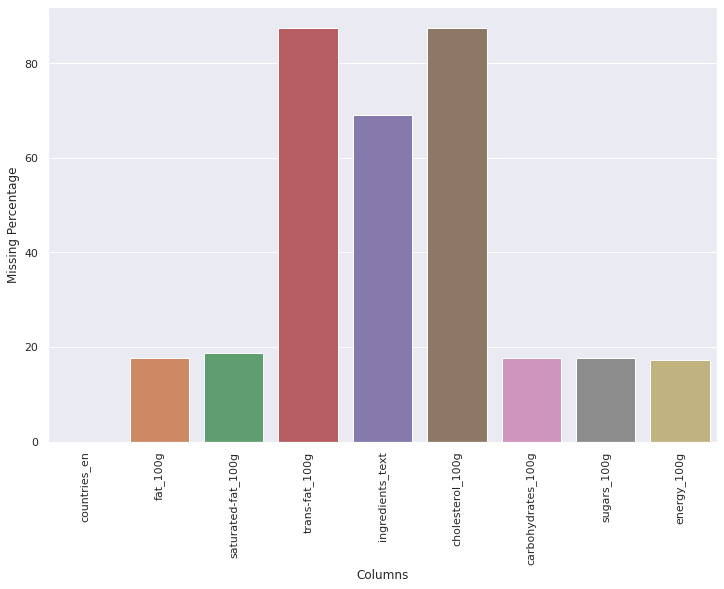

In [ ]:
ax = sns.barplot(data=missing_value_df, x="column_name", y="percent_missing")
ax.set(xlabel = "Columns", ylabel = "Missing Percentage")
ax.tick_params(axis='x', rotation=90)

In [ ]:
df.dtypes

countries_en           object
fat_100g              float32
saturated-fat_100g    float32
trans-fat_100g        float32
ingredients_text       object
cholesterol_100g      float32
carbohydrates_100g    float32
sugars_100g           float32
energy_100g           float32
dtype: object

[(-10.0, 65.0)]

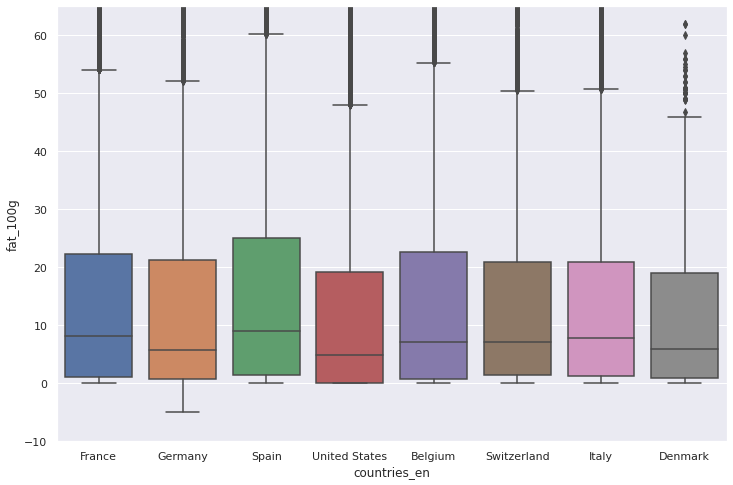

In [ ]:
# Using boxplot to visulaize the distribution of fat_100g by country
ax = sns.boxplot(x='countries_en', y='fat_100g', data=df)
ax.set(ylim=(-10, 65))

This is an interesting trend that US has one of the lowest median fat level per 100gms of food and US is still known as one of the most obese nations. While doing some literature search, I found that this trend has been already documented. For example this research mentioned this trend(Wansink, B., & Chandon, P. (2006). Can “Low-Fat” Nutrition Labels Lead to Obesity? Journal of Marketing Research, 43(4), 605–617. https://doi.org/10.1509/jmkr.43.4.605) .

[(-1.0, 20.0)]

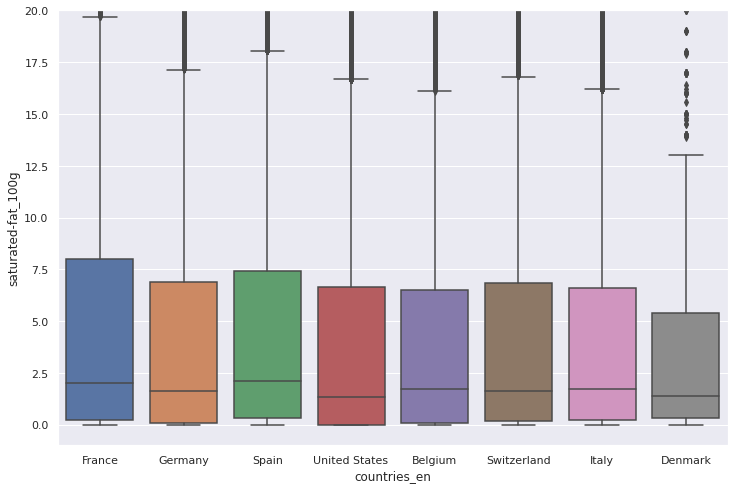

In [ ]:
# Using boxplot to visulaize the distribution of fat_100g by country
ax = sns.boxplot(x='countries_en', y='saturated-fat_100g', data=df)
ax.set(ylim=(-1, 20))

## 2.6 Top 10 Countries with almond containing products

While discussion with some families, it was interesting to learn abount Almost industry in the USA. I was curious to explore what proportion od US products contain almonds and how does it compare with other europeon countries.

Caution: Ingredient text is highly missing (~70%) in data so please interpret the results carefully.

In [ ]:
df['has_almonds'] = df.ingredients_text.str.contains('almond', case = False)

[Text(0, 0.5, 'Percentage of Products Contain Almonds'),
 Text(0.5, 0, 'Countries')]

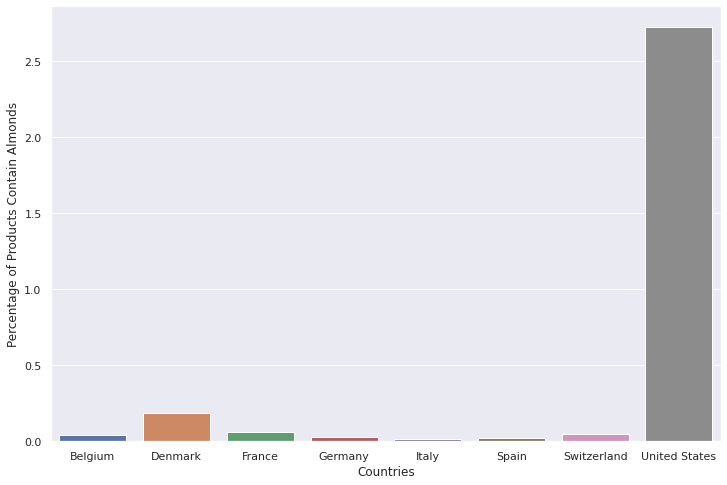

In [ ]:
df['has_almonds'].fillna(False, inplace=True)
n_almonds = pd.DataFrame({'n_almonds' : df.groupby('countries_en')['has_almonds'].sum(), 'total' : df.groupby('countries_en')['has_almonds'].count()}).reset_index()
n_almonds['pencentage_almonds'] = n_almonds['n_almonds']*100/n_almonds['total']
ax = sns.barplot(data=n_almonds, x="countries_en", y="pencentage_almonds")
ax.set(xlabel = "Countries", ylabel = "Percentage of Products Contain Almonds")

Given the high missingness, I wont try to over-interpret the results. However, if we assume that missingness is totally random, we can state that US has highes proportion of products with almonds. 

Interpretation of US data: About 2.75% of all products in this database in USA contain Almonds.

*Please note that the y axis is in percentage. So there is not no need to normalize the data*. 

### Modeling / Machine Learning 

Next we will try to find food clusters based on energy (calories), fats, carbohydrates, cholesterol, and sugars. I selected these variables because the general percention is that these variables are most closely associated obesity.

However, we noticed that trans fat and cholesterol variables are highly missing (>80) so we will not be able to use these variables.

#### Missing data handling

In [ ]:
km_df = df[['fat_100g', 
                   'saturated-fat_100g', 
          'carbohydrates_100g', 
                   'sugars_100g',
                  'energy_100g']]

In [ ]:
km_df.shape

(2074985, 5)

In [ ]:
percent_missing = km_df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': km_df.columns,
                                 'percent_missing': percent_missing})

In [ ]:
missing_value_df

,column_name,percent_missing
fat_100g,fat_100g,17.635742
saturated-fat_100g,saturated-fat_100g,18.810353
carbohydrates_100g,carbohydrates_100g,17.632995
sugars_100g,sugars_100g,17.691260
energy_100g,energy_100g,17.232462


Missingness is around 20% in remaining variables

Lets remove records with missing values


In [ ]:
km_df.dropna(inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
km_df

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,energy_100g
1,2.000000,2.00,65.000000,12.60,690.0
3,0.200000,0.10,3.900000,3.90,238.0
4,7.000000,3.08,70.099998,15.00,1569.0
7,11.000000,3.90,5.700000,0.05,812.0
8,15.100000,6.10,2.600000,1.00,3661.0
...,...,...,...,...,...
2074975,20.200001,6.00,30.900000,10.40,1393.0
2074977,7.600000,4.80,35.000000,24.00,925.0
2074978,5.000000,2.30,0.000000,0.00,548.0
2074981,0.300000,0.00,2.400000,0.60,100.0


We lost ~20% of data which is manageable.

Let see if we have any highly correlated variables

In [ ]:
km_df.corr()

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,energy_100g
fat_100g,1.000000,0.413452,4.943116e-01,0.494284,5.485886e-03
saturated-fat_100g,0.413452,1.000000,6.219806e-01,0.620926,7.064182e-04
carbohydrates_100g,0.494312,0.621981,1.000000e+00,0.999998,8.932304e-07
sugars_100g,0.494284,0.620926,9.999982e-01,1.000000,3.028139e-06
energy_100g,0.005486,0.000706,8.932304e-07,0.000003,1.000000e+00


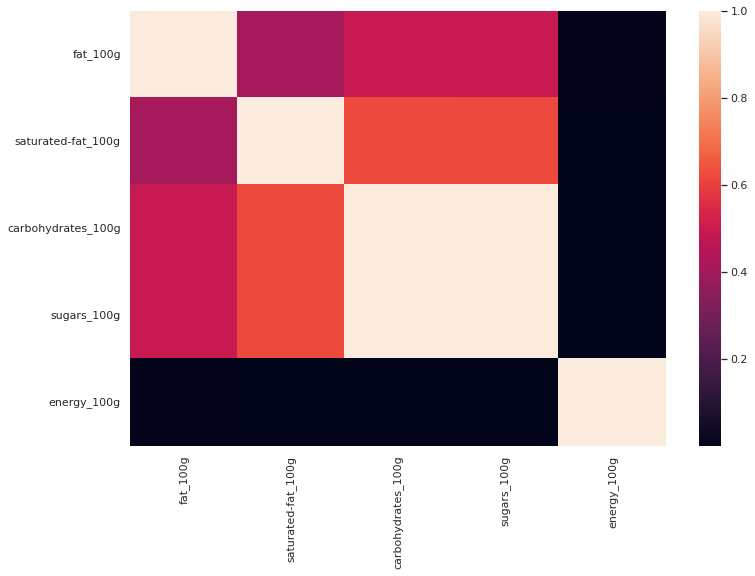

In [ ]:
sns.heatmap(km_df.corr())

I see energy is highly correlated with all variables, which makes sense. We can drop this variable.

In [ ]:
km_df.drop('energy_100g', axis = 1, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


KMeans is not a scale invariant model so we need to standardize our dataset

In [ ]:
from sklearn.preprocessing import scale
X_scaled = scale(km_df)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


First lets find out how many clusters best explain the data.

In [ ]:
from sklearn.cluster import KMeans
ssd = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(X_scaled)
    ssd.append(kmeans.inertia_)

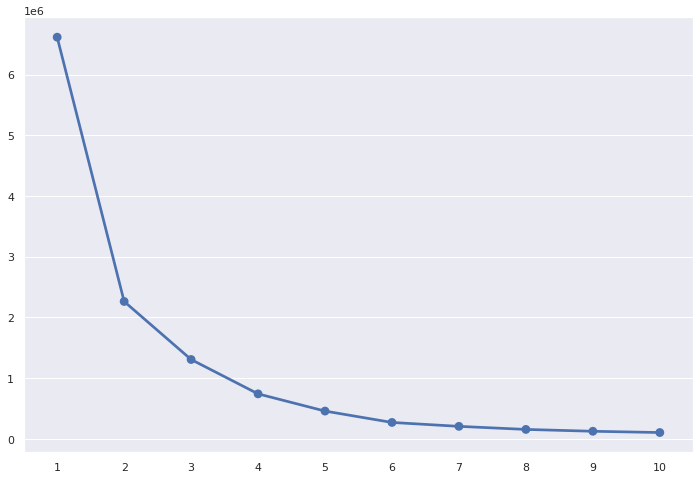

In [ ]:
sns.pointplot(y = ssd, x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Based on this plot and using the Elbow Method the best number of clusters to is 6

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 1).fit(X_scaled)

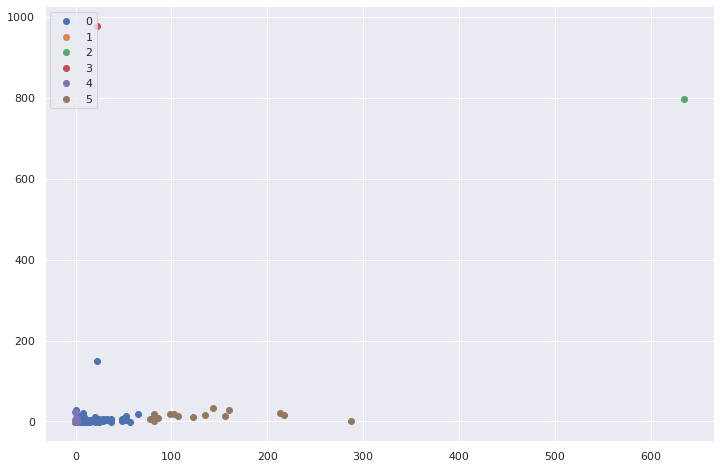

In [ ]:
label = kmeans.fit_predict(X_scaled)
 
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X_scaled[label == i , 0] , X_scaled[label == i , 1] , label = i)
plt.legend()
plt.show()

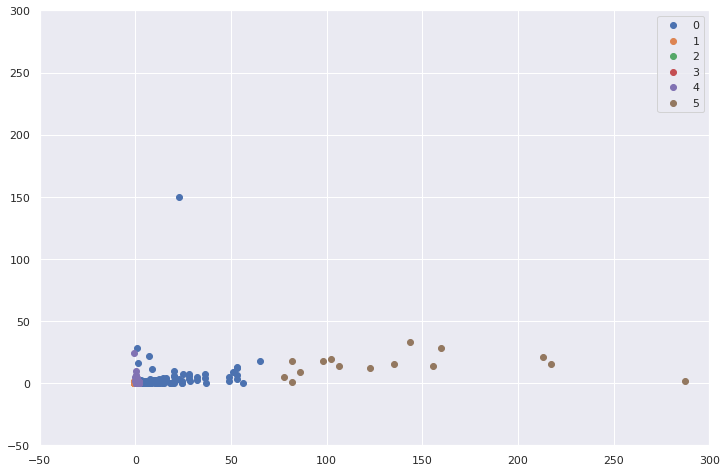

In [ ]:
for i in u_labels:
    plt.scatter(X_scaled[label == i , 0] , X_scaled[label == i , 1] , label = i)
plt.legend()
plt.ylim((-50,300))
plt.xlim((-50, 300))
plt.show()

In [ ]:
km_df['cluster'] = label

<ipython-input-68-c8b8da4e10e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  km_df['cluster'] = label


# 3 Feature Engineering 

By learning about how nutriscore was calculated, we know there are some features count as positive and others are negative. Also, there are some special rules, such as beverage and solid food were calculated in different ways. For those special rules, we set a column with boolean velue to distinguish beverage from solid food.

In order to get better predition accuracy, we refered to the following resources to decide which features to add to our models:

https://www.frontiersin.org/articles/10.3389/fnut.2022.974003/full

https://get.apicbase.com/nutri-score-science-based-nutritional-value-labelling-system/


In [ ]:
# drop colums that contain null in 'nutrisocre_score' or 'nutriscore_grade' columns.
df = df.filter(df.nutriscore_grade.isNotNull() | df.nutriscore_score.isNotNull())

In [ ]:
# drop colums that are not needed in the modeling 
cols_to_drop = [
    'url',
    'creator',
    'created_t',
    'created_datetime',
    'last_modified_t',
    'last_modified_datetime',
    'abbreviated_product_name',
    'generic_name',
    'quantity',
    'packaging',
    'packaging_tags',
    'packaging_en',
    'packaging_text',
    'brands',
    'brands_tags',
    'categories',
    'categories_en',
    'origins',
    'origins_tags',
    'origins_en',
    'manufacturing_places',
    'manufacturing_places_tags',
    'labels_en',
    'labels',
    'labels_tags',
    'emb_codes',
    'emb_codes_tags',
    'first_packaging_code_geo',
    'cities',
    'cities_tags',
    'purchase_places',
    'stores',
    'countries',
    'countries_tags',
    'ingredients_text',
    'ingredients_tags',
    'ingredients_analysis_tags',
    'allergens',
    'allergens_en',
    'traces',
    'traces_tags',
    'traces_en',
    'serving_size',
    'serving_quantity',
    'no_nutriments',
    'additives',
    'additives_tags',
    'additives_en',
    'nova_group',
    'pnns_groups_1',
    'pnns_groups_2',
    'food_groups',
    'food_groups_tags',
    'states',
    'states_tags',
    'states_en',
    'brand_owner',
    'ecoscore_grade',
    'ecoscore_score',
    'nutrient_levels_tags',
    'product_quantity',
    'owner',
    'data_quality_errors_tags',
    'unique_scans_n',
    'popularity_tags',
    'completeness',
    'last_image_t',
    'last_image_datetime',
    'main_category',
    'image_url',
    'image_small_url',
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url',
    'carbon-footprint_100g',
    'carbon-footprint-from-meat-or-fish_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g',
]
df_train = df.drop(*cols_to_drop)



In [ ]:
# Save the training data into a temp file and read from it to save memory
import pyarrow.parquet as pq
df_train.repartition(1).write.mode('overwrite').parquet('tmp/data')

In [ ]:
df_train = pd.read_parquet('tmp/data')
df_train

,code,product_name,categories_tags,countries_en,additives_n,nutriscore_score,nutriscore_grade,food_groups_en,main_category_en,energy-kj_100g,...,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000026772226,Skyr,"en:dairies,en:desserts,en:fermented-foods,en:f...",France,None,-5,a,"Milk and dairy products,Dairy desserts",Cream cheeses,None,...,None,None,None,None,None,None,None,None,None,None
1,0000000000100,moutarde au moût de raisin,"en:condiments,en:sauces,en:mustards,en:groceries",France,0,18,d,"Fats and sauces,Dressings and sauces",Groceries,936,...,None,None,None,None,None,None,None,None,None,None
2,000000000080,Pur jus de pomme,"en:plant-based-foods-and-beverages,en:beverage...",France,None,9,d,"Beverages,Fruit juices",Squeezed apple juices,None,...,None,None,None,None,None,None,None,None,None,None
3,0000000000949,Salade de carottes râpées,"en:plant-based-foods-and-beverages,en:plant-ba...",France,None,1,b,"Composite foods,One-dish meals",Seasoned grated carrots,None,...,None,None,None,None,None,None,None,None,None,None
4,0000000001281,Tarte noix de coco,"en:sweet-pies,en:pies,en:coconut-pies",France,None,14,d,"Composite foods,Pizza pies and quiches",Coconut pies,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833365,9999991149090,Riz parfumé,"en:plant-based-foods-and-beverages,en:plant-ba...",France,None,0,b,"Cereals and potatoes,Cereals",Aromatic rices,None,...,None,None,None,None,None,None,None,None,None,None
833366,9999999004360,Minis beignets,"en:snacks,en:sweet-snacks,en:sweet-fritters",France,None,15,d,None,Sweet Fritters,None,...,None,None,None,None,None,None,None,None,None,None
833367,9999999175305,Erdbeerkuchen 1019g tiefgefroren,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...",Germany,2,12,d,"Sugary snacks,Biscuits and cakes",de:tiefkühl-kuchen,925,...,None,None,None,None,None,None,None,None,None,None
833368,99999995,Steak haché 5%,"en:meats,en:beef,en:meat-patties,en:boeuf,en:s...",France,0,-2,a,"Fish‚ Meat‚ Eggs,Meat,Meat other than poultry",Viandes,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# set the type of all non-string columns to float
string_columns = ['code', 'product_name', 'categories_tags', 'countries_en', 'nutriscore_grade', 'food_groups_en', 'main_category_en'] 
float_columns = list(set(df_train.columns) - set(string_columns))
for column in float_columns:
    df_train[column] = df_train[column].astype('float')

More feature engineering related contents are combined with modeling in the session below.

# 4 Modeling 

In [ ]:
# fill the emtpy numeric data with 0
import statsmodels.api as sm

X = df_train[['salt_100g', 'sodium_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'fiber_100g', 'carbohydrates_100g', 'additives_n']]
X = X.fillna(0)
y = df_train['nutriscore_score']

In [ ]:
# remove outlier for the energy column, plot distribution
def remove_outlier(X):
    X['energy_100g'] = X['energy_100g'].clip(upper=4000)
    for c in X.columns:
        if 'energy' not in c:
            X[c] = X[c].clip(upper=100)
remove_outlier(X)

In [ ]:
# check the distribution of some features
# Show X's content
X

,salt_100g,sodium_100g,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,fiber_100g,carbohydrates_100g,additives_n
0,0.09,0.036,238.0,0.2,0.1,3.9,10.0,0.0,0.0,3.9,0.0
1,4.60,1.840,936.0,8.2,2.2,22.0,5.1,0.0,0.0,29.0,0.0
2,0.00,0.000,264.0,0.0,0.0,15.5,0.2,0.0,0.0,15.5,0.0
3,0.42,0.168,134.0,0.3,0.1,3.9,0.9,0.0,0.0,5.3,0.0
4,0.10,0.040,1594.0,22.0,15.5,21.9,4.6,0.0,4.4,27.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...
833365,0.00,0.000,1469.0,0.5,0.0,0.0,7.0,0.0,0.0,80.0,0.0
833366,1.10,0.440,1393.0,20.2,6.0,10.4,7.4,0.0,0.0,30.9,0.0
833367,0.28,0.112,925.0,7.6,4.8,24.0,2.6,12.0,0.0,35.0,2.0
833368,0.18,0.072,548.0,5.0,2.3,0.0,21.5,0.0,0.0,0.0,0.0


In [ ]:
def train_model(x, y):
    x_train_with_constant = sm.add_constant(x)
    model = sm.OLS(y, x_train_with_constant)
    model = model.fit()
    y_pred = model.predict(x_train_with_constant)
    print(np.round(np.sqrt(np.sum(((np.array(y_pred)-np.array(y))**2))/len(y_pred)),2))
    return model
model = train_model(X, y)
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


5.35


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       nutriscore_score   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 1.234e+05
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:06:54   Log-Likelihood:            -2.5797e+06
No. Observations:              833370   AIC:                         5.160e+06
Df Residuals:                  833358   BIC:                         5.160e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     1.5715      0.013    123.910      0.000       1.547       1.596
salt_100g                                                 0.6900      0.004    186.672      0.000       0.683       0.697
sodium_100g                                              -0.6364      0.006    -99.466      0.000      -0.649      -0.624
energy_100g                                               0.0031   2.48e-05    123.529      0.000       0.003       0.003
fat_100g                                                  0.0110      0.001     10.897      0.000       0.009       0.013
saturated-fat_100g                                        0.3606      0.001    348.770      0.000       0.359       0.363
sugars_100g                                               0.1991      0.000    445.059      0.000       0.198       0.200
proteins_100g                                             0.0466      0.001     59.666      0.000       0.045       0.048
fruits-vegetables-nuts-estimate-from-ingredients_100g    -0.0593      0.000   -183.184      0.000      -0.060      -0.059
fiber_100g                                               -0.3963      0.002   -244.072      0.000      -0.399      -0.393
carbohydrates_100g                                       -0.0333      0.001    -66.223      0.000      -0.034      -0.032
additives_n                                               0.3843      0.002    166.228      0.000       0.380       0.389
==============================================================================
Omnibus:                    31443.069   Durbin-Watson:                   1.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82407.041
Skew:                          -0.170   Prob(JB):                         0.00
Kurtosis:                       4.503   Cond. No.                     3.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# add boolean columns to categorize dataset
# these categoies have a different algorithm when calculating nutrition scores
 
X = df_train[['salt_100g', 'sodium_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'fiber_100g', 'carbohydrates_100g', 'additives_n', 'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts_100g']]
y = df_train['nutriscore_score']

X['is_beverage'] = 0
X['is_oil'] = 0
X['contains_fruit'] = 0
X['is_fats'] = 0
X['is_water'] = 0


X = X.fillna(0)
X.loc[df_train['categories_tags'].str.contains('en:beverages', na=False), 'is_beverage'] = 1
X.loc[df_train['categories_tags'].str.contains('oil', na=False), 'is_oil'] = 1
X.loc[df_train['categories_tags'].str.contains('fruit', na=False), 'contains_fruit'] = 1
X.loc[df_train['categories_tags'].str.contains('en:fats', na=False), 'is_fats'] = 1
X.loc[df_train['categories_tags'].str.contains('en:spring-waters', na=False), 'is_water'] = 1



<ipython-input-31-f0601ad46c3d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_beverage'] = 0
<ipython-input-31-f0601ad46c3d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_oil'] = 0
<ipython-input-31-f0601ad46c3d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [ ]:
remove_outlier(X)
model = train_model(X, y)
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


4.74


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       nutriscore_score   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                 1.087e+05
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:10:08   Log-Likelihood:            -2.4790e+06
No. Observations:              833370   AIC:                         4.958e+06
Df Residuals:                  833351   BIC:                         4.958e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.5881      0.013     43.774      0.000       0.562       0.614
salt_100g                                                 0.6931      0.003    210.941      0.000       0.687       0.700
sodium_100g                                              -0.6401      0.006   -112.776      0.000      -0.651      -0.629
energy_100g                                               0.0036   2.21e-05    162.098      0.000       0.004       0.004
fat_100g                                                  0.1020      0.001    109.785      0.000       0.100       0.104
saturated-fat_100g                                        0.3247      0.001    344.580      0.000       0.323       0.327
sugars_100g                                               0.1902      0.000    473.717      0.000       0.189       0.191
proteins_100g                                             0.0087      0.001     11.910      0.000       0.007       0.010
fruits-vegetables-nuts-estimate-from-ingredients_100g    -0.0525      0.000   -172.247      0.000      -0.053      -0.052
fiber_100g                                               -0.4137      0.001   -286.458      0.000      -0.417      -0.411
carbohydrates_100g                                       -0.0347      0.000    -77.183      0.000      -0.036      -0.034
additives_n                                               0.3334      0.002    161.204      0.000       0.329       0.337
fruits-vegetables-nuts-estimate_100g                      0.0026      0.001      3.111      0.002       0.001       0.004
fruits-vegetables-nuts_100g                              -0.0126      0.001    -13.685      0.000      -0.014      -0.011
is_beverage                                               5.9458      0.022    273.405      0.000       5.903       5.988
is_oil                                                   -3.7892      0.043    -88.889      0.000      -3.873      -3.706
contains_fruit                                           -1.5934      0.019    -85.603      0.000      -1.630      -1.557
is_fats                                                 -13.9260      0.048   -288.343      0.000     -14.021     -13.831
is_water                                                 -6.4281      0.079    -81.315      0.000      -6.583      -6.273
==============================================================================
Omnibus:                    42010.732   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           144961.300
Skew:                          -0.149   Prob(JB):                         0.00
Kurtosis:                       5.021   Cond. No.                     2.16e+04
====

## 4.1 Linear regression

In [ ]:
from sklearn.model_selection import train_test_split

# TO-DO: Conduct 80/20 train-test split with random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.20)

# Apply normalization, StandardScaler doesn't work
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)

from sklearn.metrics import mean_squared_error
import math
y_pred = reg.predict(x_train)
print(mean_squared_error(y_train, y_pred))
print(math.sqrt(mean_squared_error(y_train, y_pred)))

22.477617204584547
4.7410565493974595


In [ ]:
y_pred = reg.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

22.353363160069506
4.72793434388312


## 4.2 Decision tree

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=10)
clf = clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_train)
print('train mse', mean_squared_error(y_train, y_pred))
print('train rmse', math.sqrt(mean_squared_error(y_train, y_pred)))

train mse 1.7802330783369635
train rmse 1.3342537533531482


In [ ]:
y_pred = clf.predict(x_test)
print('test mse', mean_squared_error(y_test, y_pred))
print('test rmse', math.sqrt(mean_squared_error(y_test, y_pred)))

test mse 2.1905102124537636
test rmse 1.4800372334687273


Based on the description of how the nitrition scores were calculated, we knew there are some columns were applied by multiple algorithms based on their different ranges of values. We added features with boolen values to reflect the categories. 
The linear regresss showed a high MSE, so it did not get a satisfied accuracy since it is hard to reflect the categorical algorithms linearly. We also applied decision tree for regression and it showed a better accuracy.

# 5 Recommend a Better Alternative

Suppose a customer want to buy product "'Tomato ketchup'".

Can you recommend a better food item 
*   in the same food category
*   that has the similar nutrients such as carbohydrate,vitamin...,
*   but better (smaller) nutriscore ?



In [ ]:
# Data Preprocessing
# columns to keeps
columns_keep = [
    "product_name",
    "food_groups_en",
    "nutriscore_score",
    "serving_quantity",
    "product_quantity",
    "energy-kcal_100g",
    "fat_100g",
    "saturated-fat_100g",
    "trans-fat_100g",
    "cholesterol_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g",
    "vitamin-a_100g",
    "vitamin-c_100g",
    "calcium_100g",
    "iron_100g",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g",
    "additives_n"
] 
# df_3 = new_df.select('*', split(col("food_groups_en"),",").alias("food_groups_array"))
new_df_2 = new_df.select(columns_keep)

In [ ]:
# Since there are multiple food item with the same product name, select the Highest one
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# all rows with the same product name will be merged into one row
w2 = Window.partitionBy("product_name").orderBy(col("nutriscore_score").desc())
new_df_2 = new_df_2.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row")

# change data type
new_df_2 = new_df_2.withColumn("nutriscore_score",col("nutriscore_score").cast("float"))
new_df_2 = new_df_2.withColumn("serving_quantity",col("serving_quantity").cast("float"))
new_df_2 = new_df_2.withColumn("product_quantity",col("product_quantity").cast("float"))
new_df_2 = new_df_2.withColumn("energy-kcal_100g",col("energy-kcal_100g").cast("float"))
new_df_2 = new_df_2.withColumn("fat_100g",col("fat_100g").cast("float"))
new_df_2 = new_df_2.withColumn("saturated-fat_100g",col("saturated-fat_100g").cast("float"))
new_df_2 = new_df_2.withColumn("trans-fat_100g",col("trans-fat_100g").cast("float"))
new_df_2 = new_df_2.withColumn("cholesterol_100g",col("cholesterol_100g").cast("float"))
new_df_2 = new_df_2.withColumn("carbohydrates_100g",col("carbohydrates_100g").cast("float"))
new_df_2 = new_df_2.withColumn("sugars_100g",col("sugars_100g").cast("float"))
new_df_2 = new_df_2.withColumn("fiber_100g",col("fiber_100g").cast("float"))
new_df_2 = new_df_2.withColumn("proteins_100g",col("proteins_100g").cast("float"))
new_df_2 = new_df_2.withColumn("salt_100g",col("salt_100g").cast("float"))
new_df_2 = new_df_2.withColumn("sodium_100g",col("sodium_100g").cast("float"))
new_df_2 = new_df_2.withColumn("vitamin-a_100g",col("vitamin-a_100g").cast("float"))
new_df_2 = new_df_2.withColumn("vitamin-c_100g",col("vitamin-c_100g").cast("float"))
new_df_2 = new_df_2.withColumn("calcium_100g",col("calcium_100g").cast("float"))
new_df_2 = new_df_2.withColumn("iron_100g",col("iron_100g").cast("float"))
new_df_2 = new_df_2.withColumn("fruits-vegetables-nuts-estimate-from-ingredients_100g",col("fruits-vegetables-nuts-estimate-from-ingredients_100g").cast("float"))
new_df_2 = new_df_2.withColumn("additives_n",col("additives_n").cast("float"))
#new_df_2.printSchema()

# removing row that missing values for nutriscore_score
new_df_2 = new_df_2.filter(new_df_2.nutriscore_score.isNotNull())

# fill missing with 0
new_df_2 = new_df_2.na.fill(value=0,subset=columns_keep[2:])

new_df_2.printSchema()

For example, let's assume a customer want to buy a ketchup and the product name is "Tomato ketchup"

In [ ]:
this_product_name = 'Tomato ketchup'

In [ ]:
# find out what food catogries/ groups for "Tomato ketchup"
this_product_food_group = new_df_2.filter( new_df_2['product_name'] == this_product_name ).collect()[0][1]
this_product_food_group = this_product_food_group.split(",")
this_product_food_group

In [ ]:
from pyspark.sql.functions import split
from pyspark.sql.functions import explode
# convert column "food_groups_en" into column "food_groups_array"
new_df_3 = new_df_2.select('*', split(col("food_groups_en"),",").alias("food_groups_array"))
# explode to make each row has one food group
new_df_3 = new_df_3.select('*', explode(new_df_3.food_groups_array).alias('food_group'))
# check what food items are in the same food group
new_df_3 = new_df_3.where(col("food_group").isin(this_product_food_group))
new_df_3.show()

In [ ]:
# all rows with the same product name will be merged into one row
w2 = Window.partitionBy("product_name").orderBy(col("nutriscore_score"))
new_df_3 = new_df_3.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row")
# convert to pandas dataframe
products_df = new_df_3.toPandas()
products_df.head()

In [ ]:
# tranpose the dataframe for calculating the Correlation this product with all other products
products_trans_df = products_df.drop(columns=['food_groups_en','food_groups_array','food_group']).set_index("product_name").transpose()
print(products_trans_df.shape)
products_trans_df.head()

In [ ]:
# calculating the Correlation this product with all other products
this_product_corr  = products_trans_df.corrwith(products_trans_df[this_product_name])
this_product_corr

In [ ]:
# convert series to dataframe
this_product_corr_df = pd.DataFrame(this_product_corr,columns=['Correlation'])
this_product_corr_df.dropna(inplace=True)
this_product_corr_df.head()

In [ ]:
# join to get 'nutriscore_score','food_group' infomation of recommendations
this_product_corr_df2 = this_product_corr_df.join(products_df.set_index("product_name")[['nutriscore_score','food_group']])

# current product score
this_product_score = products_trans_df[this_product_name][0]

# showing the top 10 correlated products with better(lower value) score
this_product_corr_df2[this_product_corr_df2['nutriscore_score'] <= this_product_score ].sort_values('Correlation',ascending=False).head(10)

We found that "**Kansas City Style BBQ sauce**", "**Chef tomato ketchup**", and "**Sauce Aigre Douce**" are the top 3 highly correlated with product "**Tomato ketchup**", In other words, they have the very similar nutrients.

In addition, "**Chef tomato ketchup**", and "**Sauce Aigre Douce**" have the better(lower) nutriscore.
Therefore, both could be a better alternatives for shopping.

# 6 Conclusion

In [ ]:
# summary of our project
# Even though we had 70% of missing data we were able to come to few conclusive insights. 
# We had challenges uploading the data set but we were able to work around that.

# future plan